In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as mdt
import MDAnalysis as mda
import aimmd
import aimmd.distributed as aimmdd
import asyncmd
import asyncmd.trajectory as asynctraj
from asyncmd import Trajectory

/home/think/.conda/envs/aimmd_dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.
Tensorflow/Keras not available


In [3]:
# setup working directory

#scratch_dir = "."
#scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
scratch_dir = "/home/think/scratch/aimmd_distributed/"

workdir = os.path.join(scratch_dir, "PathSampling_mda_test")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
# have a look at the default logging level (the level used for the root logger)
print(LOGCONFIG["loggers"][""])
# have a look at the logger for aimmd
print(LOGCONFIG["loggers"]["aimmd"])
# and have a look at the log-level for the filehandler
print(LOGCONFIG["handlers"]["stdf"])
# the last two should both be `INFO`

{'level': 'WARN', 'handlers': ['stdf', 'warnout']}
{'level': 'INFO'}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [6]:
# OPTIONAL: more logging
#LOGCONFIG["handlers"]["stdf"]["level"] = "DEBUG"
#LOGCONFIG["loggers"]["aimmd"]["level"] = "DEBUG"

In [7]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "analysis_pathsampling.log")
#LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_pathsampling.log")
logging.config.dictConfig(LOGCONFIG)

# now the actual "setup"

In [8]:
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"), mode="a")

In [9]:
model = storage.rcmodels["model_to_continue_with"]

In [10]:
trainset = storage.load_trainset()

In [11]:
tasks = [aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
         aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
         aimmdd.pathsampling.DensityCollectionTask(model=model,
                                                   first_collection=100,
                                                   recreate_interval=500,
                                                   interval=10
                                                   ),
         ]

In [12]:
brain = storage.load_brain(model=model, tasks=tasks)

In [13]:
brain.total_steps

10000

In [53]:
# we can also continue the sampling since we opened the storage in append mode
await brain.run_for_n_steps(9900)

In [54]:
brain.total_steps

20001

In [55]:
# save the new model, trainset and brain state
storage.rcmodels["model_to_continue_with"] = model
storage.save_trainset(trainset)
storage.save_brain(brain)

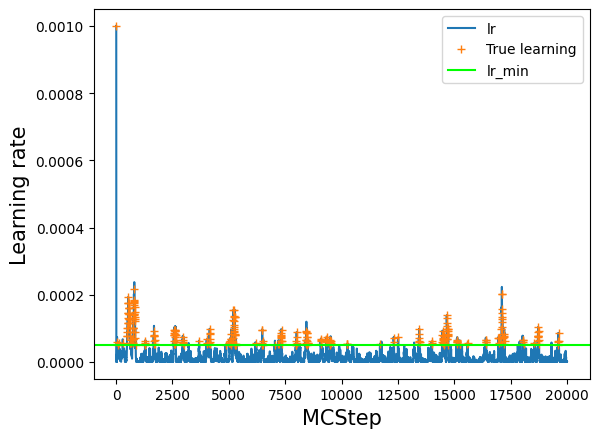

In [56]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

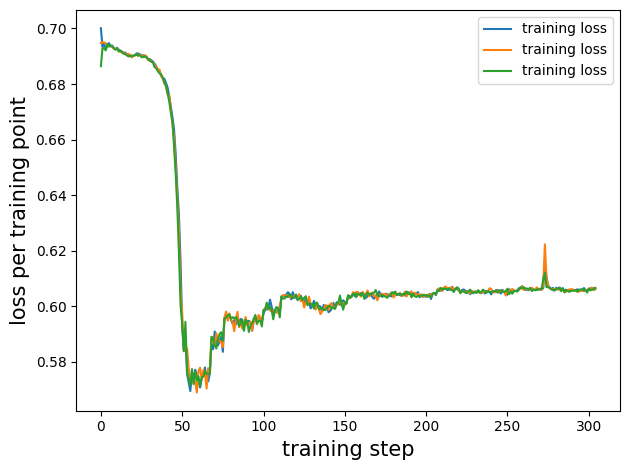

In [57]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

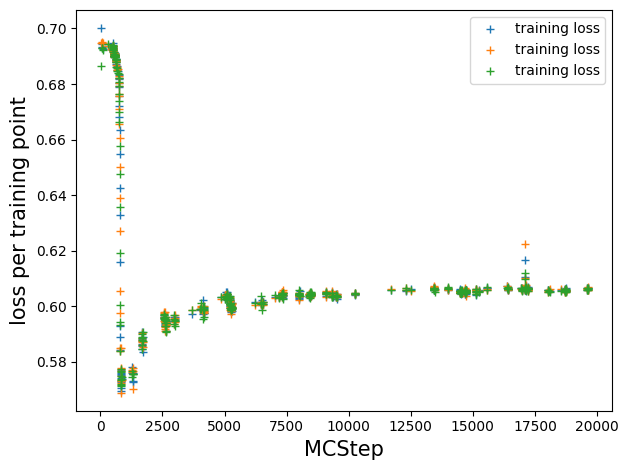

In [58]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

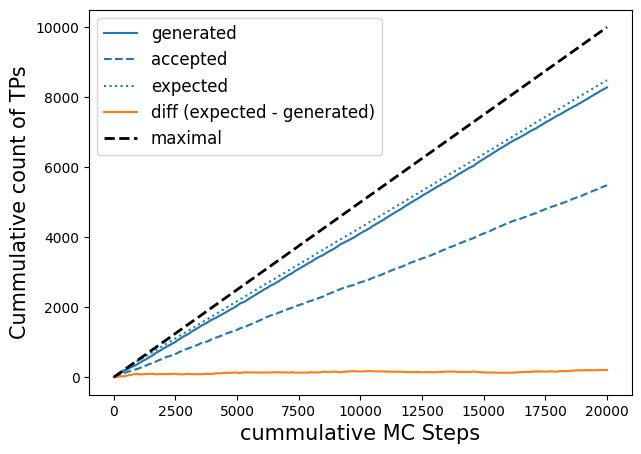

In [59]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)
fig, axs = plt.subplots(figsize=(7, 5))

n_steps = -1  # up to which step number to plot

p_ex = np.array(model.expected_p)[:n_steps]

l, = axs.plot(np.cumsum(trainset.transitions[:n_steps]), label='generated');
axs.plot(np.cumsum(brain.accepts[:n_steps]), c=l.get_color(), ls='--', label='accepted');
axs.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
axs.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions[:n_steps]), label='diff (expected - generated)')
axs.plot(np.linspace(0., len(trainset[:n_steps])/2., len(trainset[:n_steps])), c='k', ls='--', label='maximal', lw=2)
axs.legend(fontsize=12);
axs.set_ylabel('Cummulative count of TPs', size=15)
axs.set_xlabel('cummulative MC Steps', size=15);

In [60]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [61]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

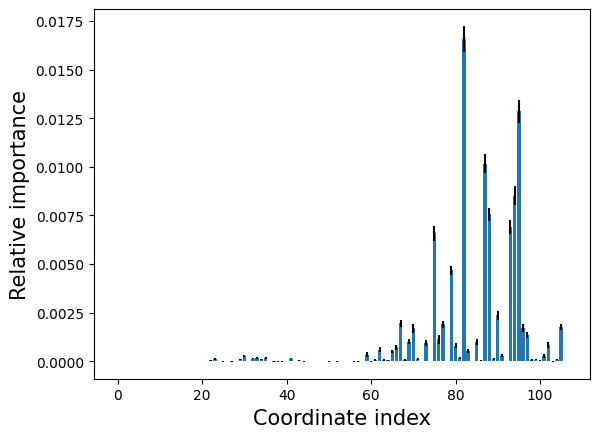

In [62]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [63]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]

# import the function used to generate the internal coordinate representation for the molecule
from state_funcs_mda import generate_atomgroups_for_ic

# and use it to get lists of pairs (distances), triples (angles) and quadruples ([pseudo-]dihedrals)
u = mda.Universe("gmx_infiles/ala_300K_amber99sb-ildn.tpr", "gmx_infiles/conf.gro",
                 refresh_offsets=True, tpr_resid_from_one=True)
molecule = u.select_atoms('protein')
pairs, triples, quadruples = generate_atomgroups_for_ic(molecule)

def pprint_atom(at):
    """Helper function to print atom information in a nice way."""
    ret = f"Atom {at.ix+1}:"
    if hasattr(at, "name"):
        ret += f" {at.name}"
    if hasattr(at, "resname"):
        ret += f" in residue {at.resname}"
    if hasattr(at, "resid"):
        ret += f" (resid {at.resid})"
    return ret

# now use all of this to print the most relevant coordinates in a remotely human understandable fashion
print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:6]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx], f" (loss diff= {hipr_plus_losses[idx] - hipr_plus_losses[-1]})")
    if idx < len(pairs[0]):
        print(f"bond between: {pprint_atom(pairs[0][idx])} and {pprint_atom(pairs[1][idx])}")
        continue
    idx -= len(pairs[0])
    if idx < len(triples[0]):
        print(f"angle between {pprint_atom(triples[0][idx])}, {pprint_atom(triples[1][idx])} and {pprint_atom(triples[2][idx])}")
        continue
    idx -= len(triples[0])
    if idx % 2 == 0:
        st = "sinus"
    else:
        st = "cosinus"
    st += f" of dihedral between {pprint_atom(quadruples[0][idx // 2])}, {pprint_atom(quadruples[1][idx // 2])}, {pprint_atom(quadruples[2][idx // 2])}"
    st += f" and {pprint_atom(quadruples[3][idx // 2])}."
    print(st)

reference loss: 0.6032916371759537

loss for idx 82:  0.6198652040054248  (loss diff= 0.016573566829471087)
cosinus of dihedral between Atom 7: N in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 15: C in residue ALA (resid 2) and Atom 17: N in residue NME (resid 3).

loss for idx 95:  0.6161498077439878  (loss diff= 0.012858170568034066)
sinus of dihedral between Atom 11: CB in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 15: C in residue ALA (resid 2) and Atom 17: N in residue NME (resid 3).

loss for idx 87:  0.6134612536951277  (loss diff= 0.01016961651917403)
sinus of dihedral between Atom 10: HA in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 11: CB in residue ALA (resid 2) and Atom 12: HB1 in residue ALA (resid 2).

loss for idx 94:  0.6118153950700902  (loss diff= 0.008523757894136508)
cosinus of dihedral between Atom 10: HA in residue ALA (resid 2), Atom 9: CA in residue ALA (resid 2), Atom 15: C in residue ALA (resid 2

In [64]:
from state_funcs_mda import descriptor_func_psi_phi

wrapped_psi_phi = asynctraj.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [65]:
mcstates_by_collection = [[state for state in collection.mcstates()] for collection in storage.mcstep_collections] 

In [66]:
accepted_steps_psi_phi_by_collection = []
for collection_states in mcstates_by_collection:
    accepted_steps_psi_phi_by_collection.append(await asyncio.gather(*(wrapped_psi_phi(s.path) for s in collection_states)))

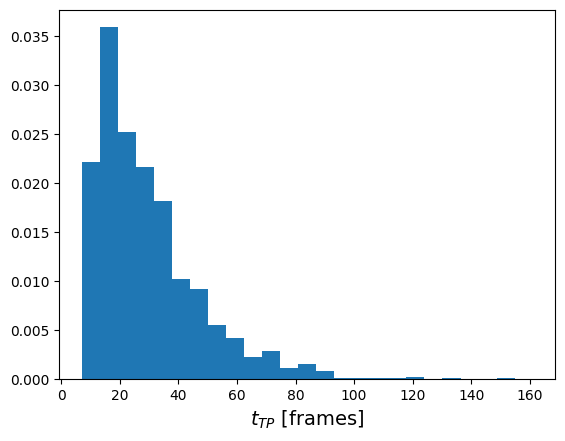

In [67]:
# plot transition path time distribution
fig, axs = plt.subplots()

t_TP_in_frames = [len(s.path) for s in collection_states for collection_states in mcstates_by_collection]

axs.hist(t_TP_in_frames, bins=25, density=True)
axs.set_xlabel("$t_{TP}$ [frames]", size=14);

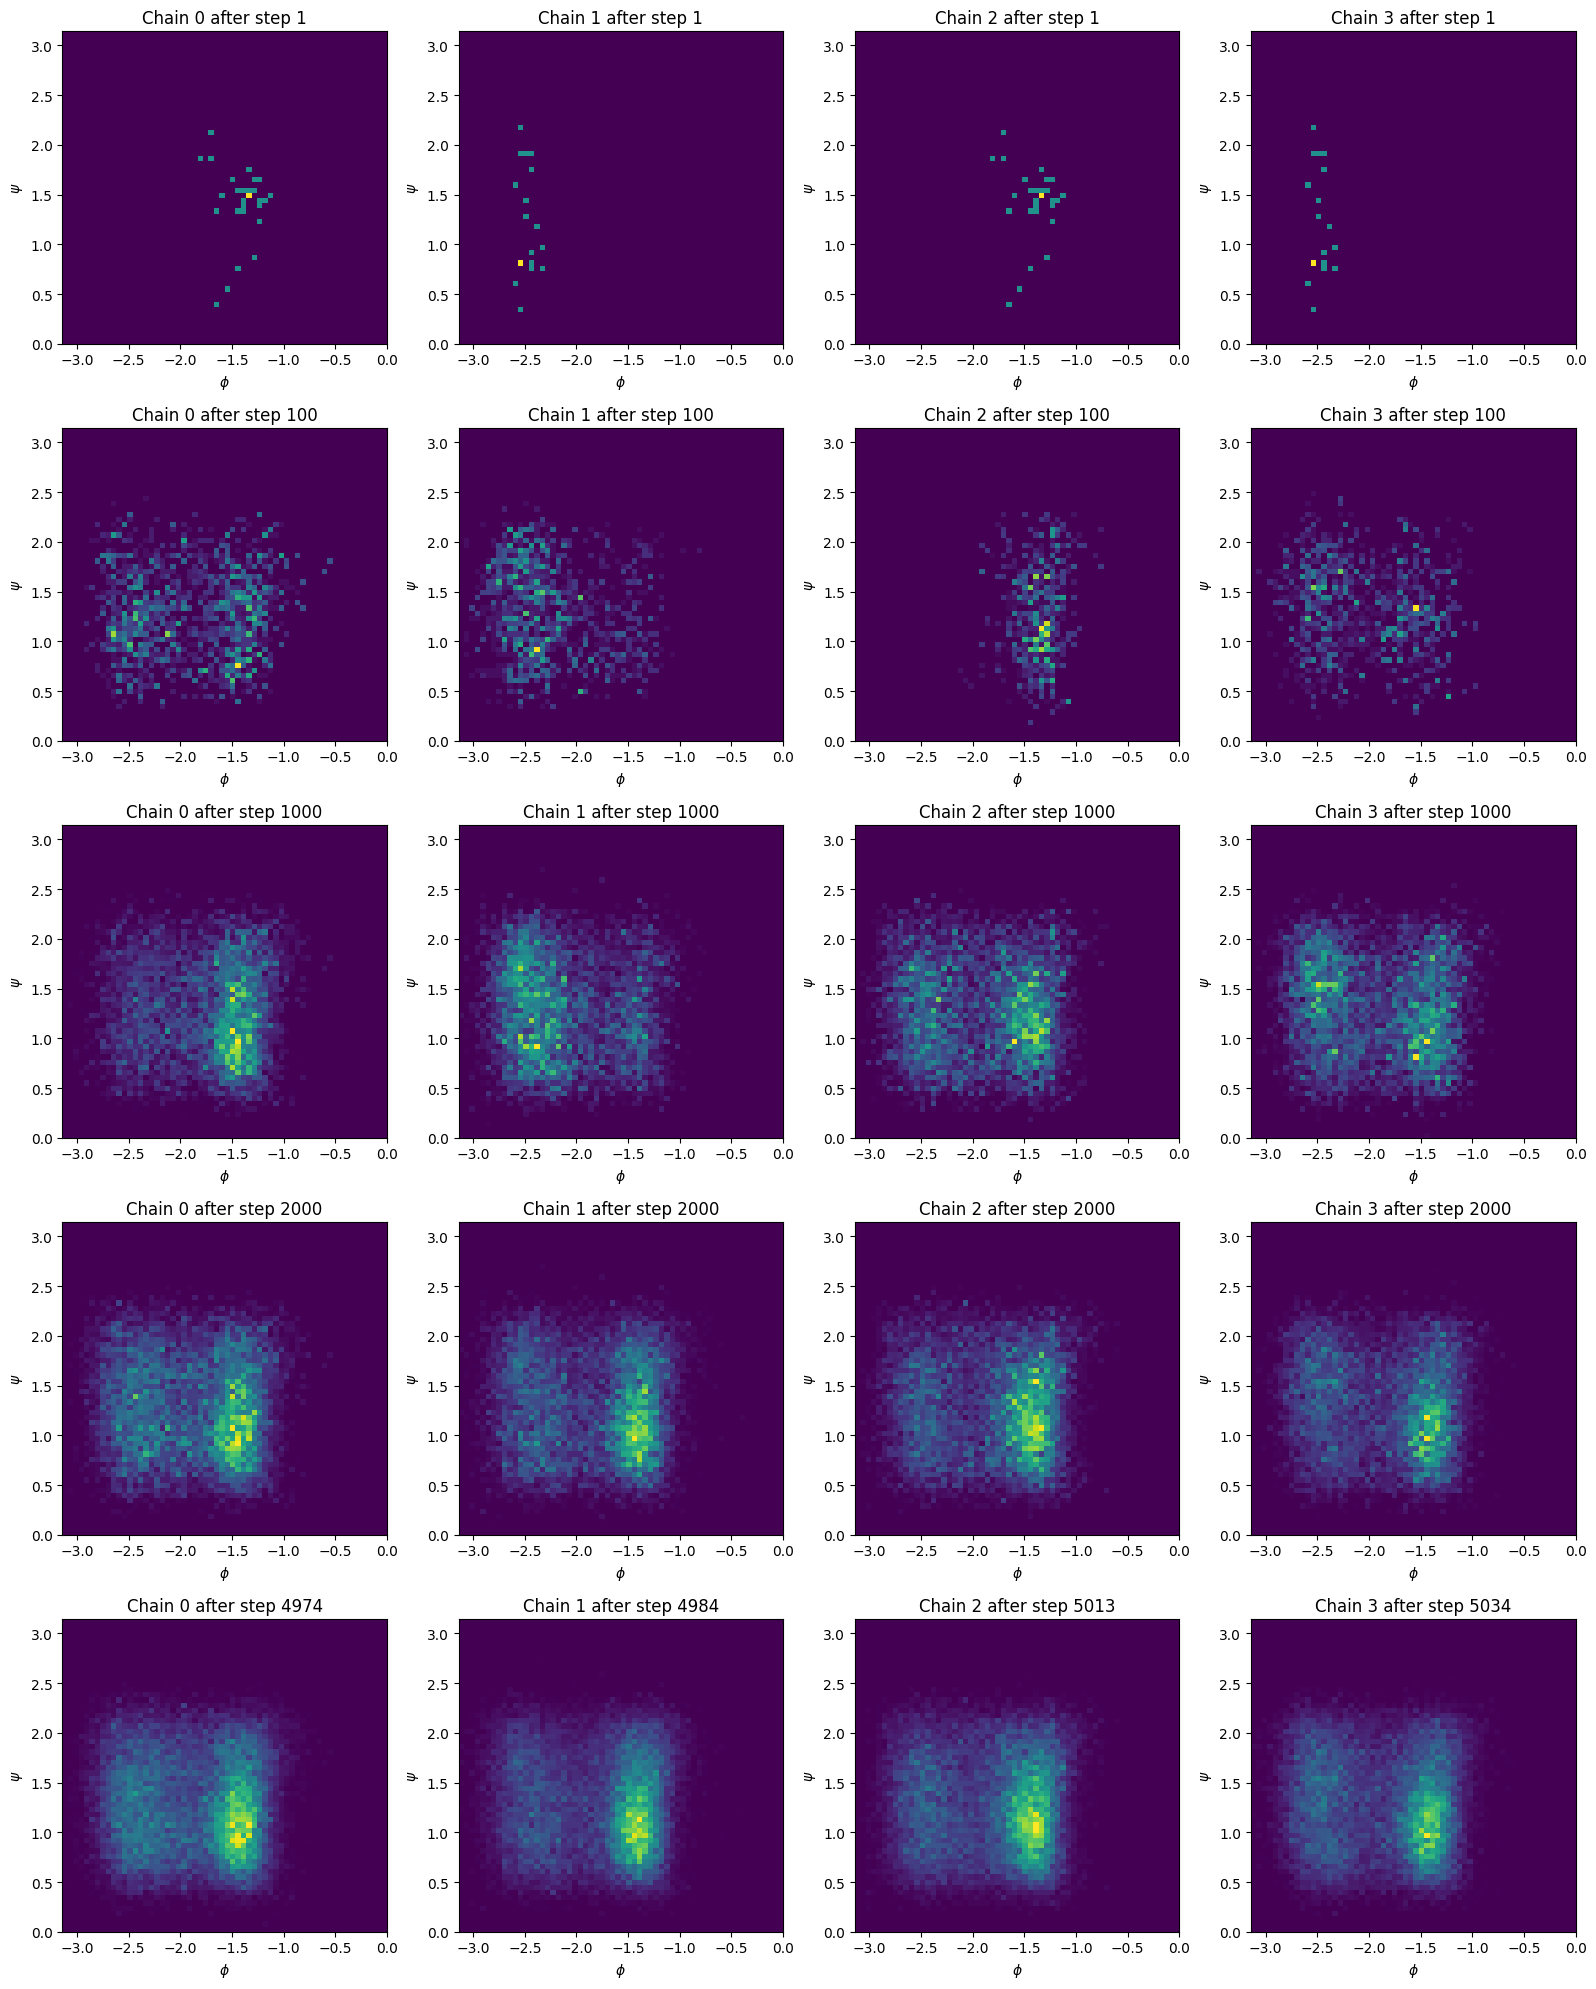

In [68]:
steps_done = [1, 100, 1000, 2000, None]  # the None gives us the last step for all chains

fig, axs = plt.subplots(ncols=len(storage.mcstep_collections), nrows=len(steps_done),
                        figsize=(len(storage.mcstep_collections)*4, 4*len(steps_done)))

for max_step, axs_array in zip(steps_done, axs):
    for c_idx, ax in enumerate(axs_array):
        ax.set_title(f"Chain {c_idx} after step {len(accepted_steps_psi_phi_by_collection[c_idx][:max_step])}")
        ax.set_xlabel("$\phi$")
        ax.set_ylabel("$\psi$")
        plot_data = np.concatenate(accepted_steps_psi_phi_by_collection[c_idx][:max_step], axis=0)
        ax.hist2d(plot_data[:, 1], plot_data[:, 0], bins=(60, 60), range=((-np.pi, 0), (0, np.pi)), density=True)
        ax.set_xlim(-np.pi, 0)
        ax.set_ylim(0, np.pi)

fig.tight_layout()

#plt.savefig("p_x_TP_for_each_chain_small.pdf")

In [69]:
histo_per_collection = []
for i in range(len(brain.samplers)):
    plot_data = np.concatenate(accepted_steps_psi_phi_by_collection[i], axis=0)
    h, xedges, yedges = np.histogram2d(plot_data[:, 1], plot_data[:, 0], bins=(60, 60), range=((-np.pi, 0), (0, np.pi)), density=True)
    histo_per_collection.append(h)

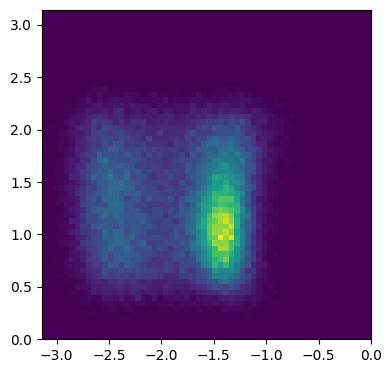

In [71]:
# plot the combined histogram
fig, axs = plt.subplots(figsize=(4, 4))

axs.imshow(np.mean(histo_per_collection, axis=0).T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower")
ax.set_xlabel("$\phi$")
ax.set_ylabel("$\psi$")
    
fig.tight_layout()

In [72]:
from scipy.spatial import distance

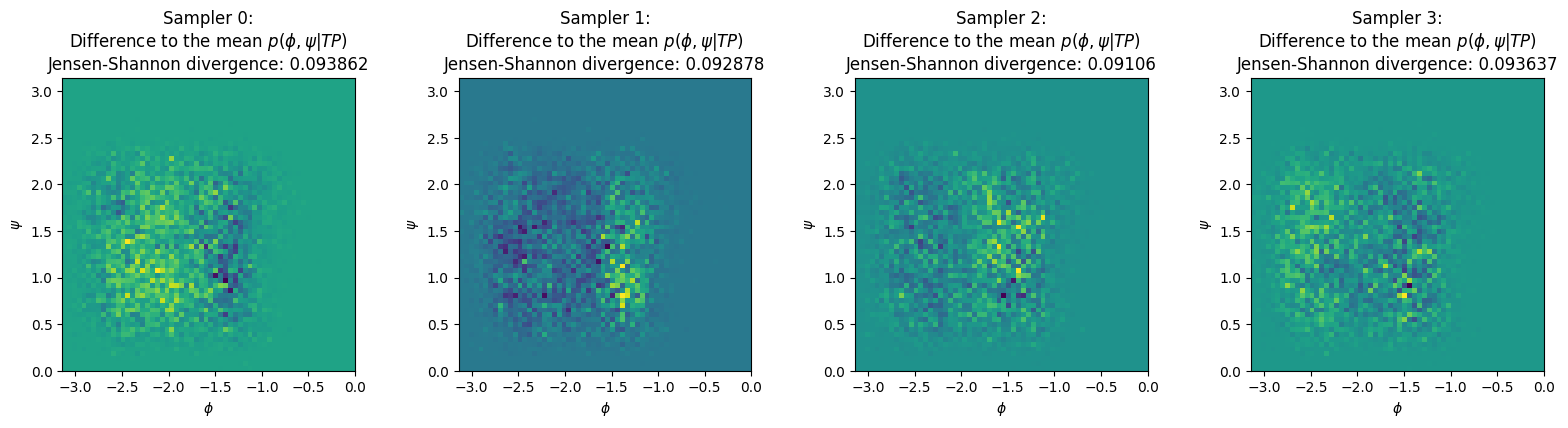

In [73]:
fig, axs = plt.subplots(ncols=4, figsize=(4*4, 4))

for cidx, (h, ax) in enumerate(zip(histo_per_collection, axs)):
    q = h.T
    p = np.mean(histo_per_collection, axis=0).T
    mapp = ax.imshow(q - p, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower")
    ax.set_title(f"Sampler {cidx}:\nDifference to the mean $p(\phi, \psi| TP)$\nJensen-Shannon divergence: {round(distance.jensenshannon(p.flatten(), q.flatten()), 6)}")
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("$\psi$")
    
fig.tight_layout()

In [42]:
storage.close()